### import library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import math

### membaca folder pada dataset

In [2]:
dataset = "dataset"
folders = [folder for folder in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, folder))]

### membaca file pada dataset

In [3]:
num_files = np.array([len(os.listdir(os.path.join(dataset, folder))) for folder in folders])

### menampilkan jumlah file pada tiap folder

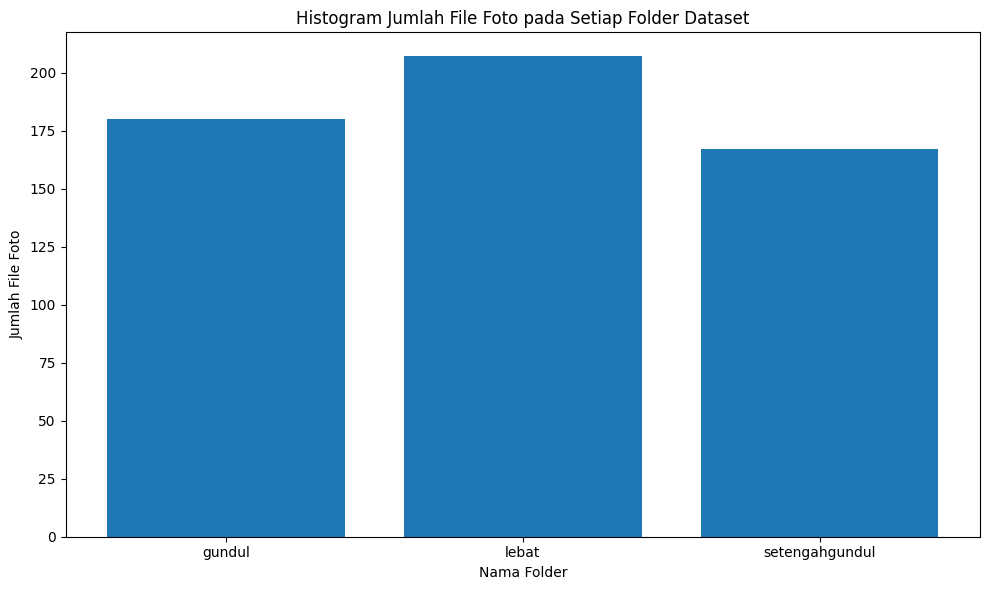

In [4]:
plt.figure(figsize=(10, 6))
plt.bar(folders, num_files)
plt.xlabel('Nama Folder')
plt.ylabel('Jumlah File Foto')
plt.title('Histogram Jumlah File Foto pada Setiap Folder Dataset')
plt.tight_layout()
plt.show()

### mendefinisikan fungsi untuk membaca gambar

In [5]:
def insertGambar(folder, num_records, new_size=None):
    data = []
    labels = []
    filenames = []
    datalabel = []
    
    for label in os.listdir(folder):
        datalabel.append(label)
        print(f"Processing label: {label}")
        img_count = 0
        for filename in os.listdir(os.path.join(folder, label)):
            if img_count >= num_records:
                break
            img_path = os.path.join(folder, label, filename)
            img = cv2.imread(img_path)
            if img is not None:
                if new_size:
                    img = cv2.resize(img, new_size)
                data.append(img)
                labels.append(label)
                filenames.append(filename)
                img_count += 1

    return data, filenames, datalabel, labels

In [6]:
data, filenames, datalabel, labels = insertGambar(dataset, 165, new_size=(150, 150))

Processing label: gundul
Processing label: lebat
Processing label: setengahgundul


### mendefinisikan fungsi untuk menampilkan gambar sesuai label

In [7]:
def imageByLabel(dataset):
    folders = [folder for folder in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, folder))]
    
    fig, axs = plt.subplots(1, len(folders), figsize=(15, 5))
    for i, folder in enumerate(folders):
        folder_path = os.path.join(dataset, folder)
        image_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg') or file.endswith('.png')]
        
        if len(image_files) > 0:
            random_image = random.choice(image_files)
            img_path = os.path.join(folder_path, random_image)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axs[i].imshow(img)
            axs[i].set_title(f"Label: {folder}")
            axs[i].axis('off')

    plt.show()

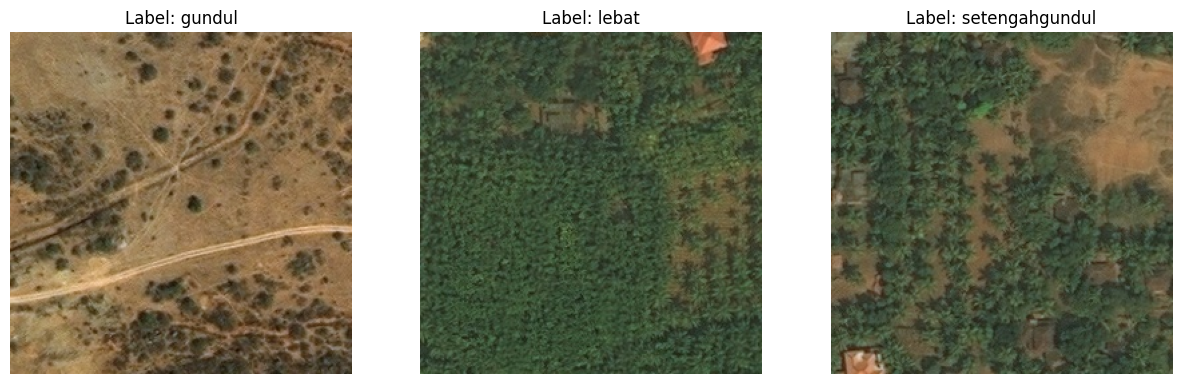

In [8]:
imageByLabel(dataset)

### mendefinisikan fungsi rotate untuk keperluan augmentasi

In [9]:
def rotate(image, angle):
    height, width = image.shape[:2]

    center_x = width // 2
    center_y = height // 2

    angle_radian = np.radians(angle)

    cos_angle = np.cos(angle_radian)
    sin_angle = np.sin(angle_radian)
    
    rotated_image = np.zeros_like(image)
    for y in range(height):
        for x in range(width):
            new_x = int((x - center_x) * cos_angle - (y - center_y) * sin_angle + center_x)
            new_y = int((x - center_x) * sin_angle + (y - center_y) * cos_angle + center_y)

            if 0 <= new_x < width and 0 <= new_y < height:
                rotated_image[new_y, new_x] = image[y, x]
    
    return rotated_image

### melakukan augmentasi citra dengan merotasi 90 derajat 150 citra

In [10]:
num_photos = 150
count = 0

for i in range(len(data)):
    if count >= num_photos:
        break

    img = data[i]
    label = labels[i]

    rotated_image = rotate(img, 90)

    data.append(rotated_image)
    labels.append(label)
    
    count += 1

In [11]:
def show_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

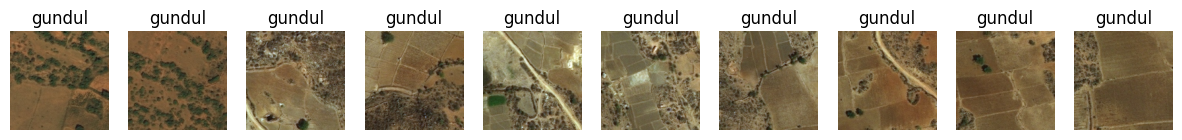

In [12]:
show_images(data[:10], labels[:10])

### mendefinisikan fungsi glcm

In [13]:
def glcm0(img):
    max_val = np.max(img)
    imgTemp = np.zeros([max_val+1, max_val+1])

    for i in range(len(img)):
        for j in range(len(img[i])-1):
            imgTemp[img[i, j], img[i, j+1]] += 1

    data = imgTemp + np.transpose(imgTemp)
    temp = np.sum(data)

    if temp != 0:
        data /= temp

    return data

In [14]:
def glcm45(img):
    max_val = np.max(img)
    imgTemp = np.zeros([max_val+1, max_val+1])

    for i in range(len(img)-1):
        for j in range(len(img[i])-1):
            imgTemp[img[i+1, j], img[i, j+1]] += 1

    data = imgTemp + np.transpose(imgTemp)
    temp = np.sum(data)

    if temp != 0:
        data /= temp

    return data

In [15]:
def glcm90(img):
    max_val = np.max(img)
    imgTemp = np.zeros([max_val+1, max_val+1])

    for i in range(len(img)-1):
        for j in range(len(img[i])):
            imgTemp[img[i+1, j], img[i, j]] += 1

    data = imgTemp + np.transpose(imgTemp)
    temp = np.sum(data)

    if temp != 0:
        data /= temp

    return data

In [16]:
def glcm135(img):
    max_val = np.max(img)
    imgTemp = np.zeros([max_val+1, max_val+1])

    for i in range(len(img)-1):
        for j in range(len(img[i])-1):
            imgTemp[img[i, j], img[i+1, j+1]] += 1

    data = imgTemp + np.transpose(imgTemp)
    temp = np.sum(data)

    if temp != 0:
        data /= temp

    return data

### mendefinisikan fungsi untuk ekstraksi fitur

In [17]:
def contrast(data):
    contrast = 0
    for i in range(len(data)):
        for j in range(len(data)):
            contrast += data[i,j] + (i-j)**2
            
    return contrast

In [18]:
def dissimilarity(data):
    diss = 0
    for i in range (len(data)):
        for j in range(len(data)):
            diss += data[i,j] + abs(i-j)
            
    return diss

In [19]:
def homogenity(data):
    homogen = 0
    for i in range (len(data)):
        for j in range(len(data)):
            homogen += data[i,j] / (1 + abs(i-j))

    return homogen

In [20]:
def energy(data):
    energy = 0
    for i in range (len(data)):
        for j in range(len(data)):
            energy += pow(data[i,j], 2)
    return energy

In [21]:
def calculate_correlation(data, mean_i, mean_j, std_dev_i, std_dev_j):
    if std_dev_i == 0 or std_dev_j == 0:
        return 0
    
    corr = 0
    for i in range(len(data)):
        for j in range(len(data)):
            corr += ((i - mean_i) * (j - mean_j) * data[i, j]) / (std_dev_i * std_dev_j)
            
    return corr

In [22]:
def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data)):
            if data[i,j] > 0:
                entropy += -(data[i,j] * math.log(data[i,j]))
                
    return entropy

In [23]:
def ASM(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
            
    return asm

In [24]:
def mean_i(data):
    mean_value = 0
    for i in range(len(data)):
        for j in range(len(data)):
            mean_value += i * data[i, j]

    return mean_value

In [25]:
def mean_j(data):
    mean_value = 0
    for i in range(len(data)):
        for j in range(len(data)):
            mean_value += j * data[i, j]

    return mean_value

In [26]:
def std_dev_i(data, mean_i_value):
    std_dev_value = 0
    
    for i in range(len(data)):
        for j in range(len(data)):
            std_dev_value += pow((i - mean_i_value), 2) * data[i, j]

    std_dev_value = math.sqrt(std_dev_value)

    return std_dev_value

In [27]:
def std_dev_j(data, mean_j_value):
    std_dev_value = 0
    
    for i in range(len(data)):
        for j in range(len(data)):
            std_dev_value += pow((j - mean_j_value), 2) * data[i, j]

    std_dev_value = math.sqrt(std_dev_value)
    
    return std_dev_value

### mendefinisikan fungsi analisis fitur

In [29]:
def featureAnalysis(result, labels):
    part = []
    correlation_val = []

    for i, glcm_matrix in enumerate(result):
        save = []

        for j in glcm_matrix:
            kontras = contrast(j)
            save.append(kontras)

            diss = dissimilarity(j)
            save.append(diss)

            hom = homogenity(j)
            save.append(hom)

            eng = energy(j)
            save.append(eng)
            
            mI = mean_i(j)
            mJ = mean_j(j)
            sDI = std_dev_i(j, mI)
            sDJ = std_dev_j(j, mJ)
            corr = calculate_correlation(j, mI, mJ, sDI, sDJ)
            save.append(corr)
            
            ent = entropy(j)
            save.append(ent)
            
            asm_value = ASM(j)
            save.append(asm_value)

        save.append(labels[i])
        part.append(save)

        if all(value != 0 for value in [kontras, diss, hom, eng, corr, ent, asm_value]):
            correlation_val.append((kontras, diss, hom, eng, corr, ent, asm_value))

    return part, correlation_val

### mendefinisikan fungsi untuk menghitung skor dari tiap fitur

In [6]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer

In [7]:
def features_score(data, label_column):
    X = data.drop(columns=[label_column])
    y = data[label_column]

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    min_val = np.min(X_imputed)
    if min_val < 0:
        X_imputed += abs(min_val)

    selector = SelectKBest(score_func=chi2)
    selector.fit(X_imputed, y)

    scores = selector.scores_

    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})

    feature_scores = feature_scores.sort_values(by='Score', ascending=False)

    return feature_scores

### membuat dictionary nama kolom pada dataframe hasil ekstraksi fitur

In [32]:
headerCols = ['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
            'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135',
            'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135',
            'energy_0', 'energy_45', 'energy_90', 'energy_135',
            'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135',
            'entropy_0', 'entropy_45', 'entropy_90', 'entropy_135',
            'asm_0', 'asm_45', 'asm_90', 'asm_135', 'labels']

### mendefinisikan fungsi normalize untuk menormalisasi data

In [16]:
def normalize(train, test):
    train = train.astype(np.float32)
    test = test.astype(np.float32)
    
    min_vals = train.min(axis=0)
    max_vals = train.max(axis=0)
    
    train_normalized = (train - min_vals) / (max_vals - min_vals)
    test_normalized = (test - min_vals) / (max_vals - min_vals)
    
    return train_normalized, test_normalized

### mendefinisikan fungsi untuk mengevaluasi data pada 3 model: KNN, SVM, dan RF

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def evaluate_model(model, X_test_scaled, y_test, model_name):
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f'{model_name} - Accuracy: {accuracy:.6f}')
    print(f'{model_name} - Precision: {precision:.6f}')
    print(f'{model_name} - Recall: {recall:.6f}')
    print(f'{model_name} - F1-Score: {f1:.6f}')
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'\nConfusion Matrix for {model_name}:')
    print(conf_matrix)
    
    plt.figure(figsize=(8, 6))
    mask = (np.eye(len(conf_matrix)) == 1)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', mask=mask, cbar=False)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', mask=~mask, cbar=False)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    return accuracy, precision, recall, f1

### Melakukan proses menghitung glcm dari citra original

In [36]:
hasil_ori = []
for img in data:
    res_ori = []
    res_ori.append(glcm0(img))
    res_ori.append(glcm45(img))
    res_ori.append(glcm90(img))
    res_ori.append(glcm135(img))
    hasil_ori.append(res_ori)

### melakukan ekstraksi fitur dari glcm citra original

In [37]:
part_original, corr_value_ori = featureAnalysis(hasil_ori, labels)

### membuat hasil ekstraksi fitur dalam bentuk dataframe

In [38]:
df = pd.DataFrame(part_original, columns=headerCols)

### membuat file csv dari dataframe

In [39]:
df.to_csv('hasilPercobaan5_original.csv',index=False)

In [4]:
results_ori = pd.read_csv('hasilPercobaan5_original.csv')
results_ori

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,entropy_0,entropy_45,entropy_90,entropy_135,asm_0,asm_45,asm_90,asm_135,labels
0,1.563100e+08,1.786401e+06,0.273404,0.000521,0.957049,8.050887,0.000521,1.563100e+08,1.786401e+06,0.241591,...,8.185899,0.000465,1.563100e+08,1.786401e+06,0.239697,0.000430,0.924681,8.278883,0.000430,gundul
1,9.870276e+07,1.265421e+06,0.258627,0.000509,0.948812,8.045545,0.000509,9.870276e+07,1.265421e+06,0.225281,...,8.158310,0.000463,9.870276e+07,1.265421e+06,0.225877,0.000421,0.911318,8.264633,0.000421,gundul
2,6.937083e+08,5.462271e+06,0.185760,0.000196,0.880890,8.934065,0.000196,6.937083e+08,5.462271e+06,0.159872,...,8.999593,0.000181,6.937083e+08,5.462271e+06,0.169016,0.000169,0.819401,9.088853,0.000169,gundul
3,6.828480e+08,5.398009e+06,0.210396,0.000243,0.929353,8.630762,0.000243,6.828480e+08,5.398009e+06,0.183050,...,8.745404,0.000217,6.828480e+08,5.398009e+06,0.182902,0.000197,0.879137,8.848902,0.000197,gundul
4,7.158170e+08,5.592321e+06,0.191683,0.000180,0.920213,9.078148,0.000180,7.158170e+08,5.592321e+06,0.164966,...,9.060133,0.000179,7.158170e+08,5.592321e+06,0.182097,0.000163,0.905318,9.154707,0.000163,gundul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,1.176475e+08,1.443529e+06,0.282424,0.000517,0.921860,7.990418,0.000517,1.176475e+08,1.443529e+06,0.271711,...,8.011871,0.000508,1.176475e+08,1.443529e+06,0.267128,0.000475,0.896958,8.116384,0.000475,gundul
641,2.126590e+08,2.250361e+06,0.268235,0.000444,0.911288,8.163831,0.000444,2.126590e+08,2.250361e+06,0.247778,...,8.274789,0.000415,2.126590e+08,2.250361e+06,0.239674,0.000379,0.863285,8.391750,0.000379,gundul
642,1.599136e+08,1.817201e+06,0.258979,0.000492,0.905979,8.150302,0.000492,1.599136e+08,1.817201e+06,0.240870,...,8.000178,0.000559,1.599136e+08,1.817201e+06,0.239932,0.000440,0.885112,8.271570,0.000440,gundul
643,6.103543e+08,4.962231e+06,0.203459,0.000306,0.832739,8.460746,0.000306,6.103543e+08,4.962231e+06,0.184246,...,8.331772,0.000351,6.103543e+08,4.962231e+06,0.189114,0.000276,0.792934,8.559551,0.000276,gundul


### mengetahui skor dari tiap fitur

In [8]:
best_features_ori = features_score(results_ori, 'labels')

print("Fitur terbaik berdasarkan skor:")
print(best_features_ori)

Fitur terbaik berdasarkan skor:
              Feature         Score
0          contrast_0  9.187013e+09
14          energy_90  9.187013e+09
21         entropy_45  9.187013e+09
7   dissimilarity_135  9.187013e+09
1         contrast_45  5.648273e+07
8       homogeneity_0  5.648273e+07
15         energy_135  5.648273e+07
22         entropy_90  5.648273e+07
25             asm_45  6.424699e+00
11    homogeneity_135  5.005895e+00
18     correlation_90  4.130183e+00
12           energy_0  3.985484e+00
26             asm_90  3.799262e+00
5    dissimilarity_45  3.780731e+00
19    correlation_135  3.342030e+00
4     dissimilarity_0  2.346002e+00
23        entropy_135  1.081356e+00
16      correlation_0  1.000139e+00
9      homogeneity_45  7.858732e-01
2         contrast_90  5.876036e-01
3        contrast_135  1.114089e-02
6    dissimilarity_90  1.114089e-02
13          energy_45  9.621619e-03
10     homogeneity_90  9.621619e-03
20          entropy_0  9.246955e-03
17     correlation_45  9.246955e

In [9]:
from sklearn.model_selection import train_test_split

### melakukan percobaan dengan fitur skor di atas 0

In [10]:
dataTrain_ori = pd.read_csv('hasilPercobaan5_original.csv')

X = dataTrain_ori[['contrast_0', 'energy_90', 'entropy_45', 'dissimilarity_135', 'contrast_45', 'homogeneity_0', 'energy_135', 'entropy_90', 'asm_45', 'homogeneity_135', 'correlation_90', 'energy_0', 'asm_90', 'dissimilarity_45', 'correlation_135', 'dissimilarity_0', 'entropy_135', 'correlation_0']]
y = dataTrain_ori['labels']

X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
X_train_ori_scaled, X_test_ori_scaled = normalize(X_train_ori, X_test_ori)

In [18]:
print("Data Pelatihan Setelah Normalisasi Min-Max:")
print(X_train_ori_scaled)
print("\nData Pengujian Setelah Normalisasi Min-Max:")
print(X_test_ori_scaled)

Data Pelatihan Setelah Normalisasi Min-Max:
     contrast_0  energy_90  entropy_45  dissimilarity_135  contrast_45  \
429    0.984225   0.984225    0.984225           0.984225     0.987797   
210    0.131836   0.131836    0.131836           0.131836     0.200351   
9      0.227222   0.227222    0.227222           0.227222     0.311954   
519    0.795423   0.795423    0.795423           0.795423     0.837693   
268    0.067778   0.067778    0.067778           0.067778     0.114799   
..          ...        ...         ...                ...          ...   
71     0.634716   0.634716    0.634716           0.634716     0.702880   
106    0.279848   0.279848    0.279848           0.279848     0.368616   
270    0.047955   0.047955    0.047955           0.047955     0.085251   
435    1.000000   1.000000    1.000000           1.000000     1.000000   
102    0.131836   0.131836    0.131836           0.131836     0.200351   

     homogeneity_0  energy_135  entropy_90    asm_45  homogeneity_1

K-Nearest Neighbors - Accuracy: 0.840206
K-Nearest Neighbors - Precision: 0.810223
K-Nearest Neighbors - Recall: 0.792032
K-Nearest Neighbors - F1-Score: 0.796053

Confusion Matrix for K-Nearest Neighbors:
[[89  3  7]
 [ 0 54  2]
 [15  4 20]]


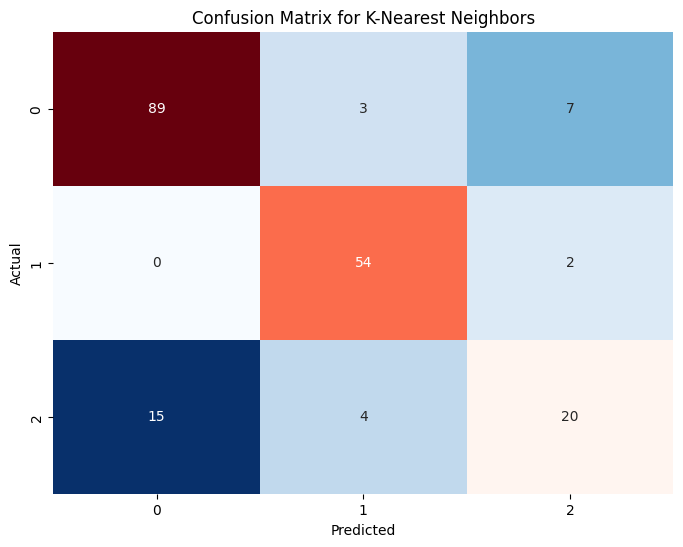

In [19]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_ori_scaled, y_train_ori)
knn_metrics = evaluate_model(knn_model, X_test_ori_scaled, y_test_ori, 'K-Nearest Neighbors')

SVM - Accuracy: 0.871134
SVM - Precision: 0.861823
SVM - Recall: 0.819999
SVM - F1-Score: 0.830993

Confusion Matrix for SVM:
[[93  2  4]
 [ 0 55  1]
 [15  3 21]]


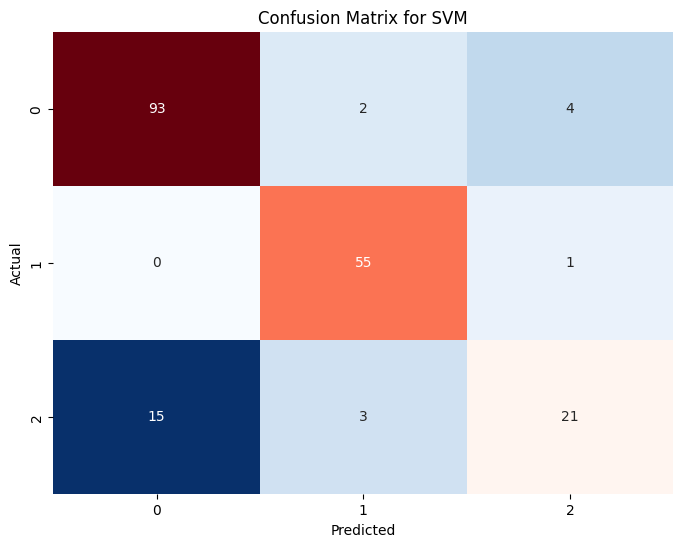

In [20]:
svm_model = SVC()
svm_model.fit(X_train_ori_scaled, y_train_ori)
svm_metrics = evaluate_model(svm_model, X_test_ori_scaled, y_test_ori, 'SVM')

Random Forest - Accuracy: 0.855670
Random Forest - Precision: 0.831852
Random Forest - Recall: 0.825448
Random Forest - F1-Score: 0.828240

Confusion Matrix for Random Forest:
[[88  2  9]
 [ 1 53  2]
 [12  2 25]]


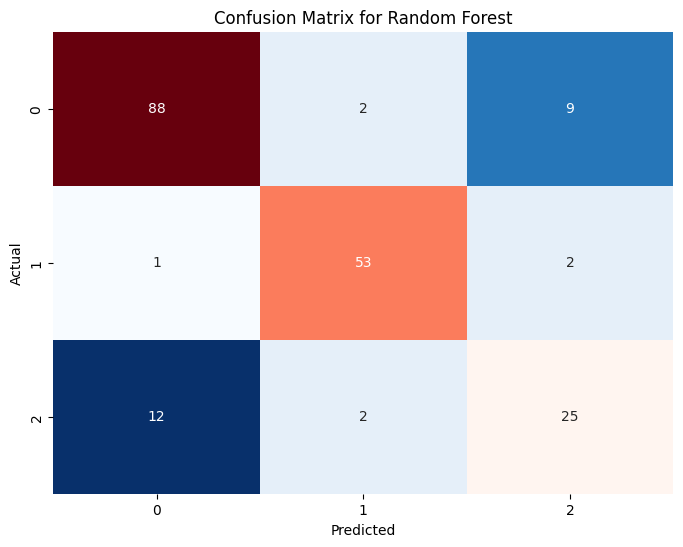

In [21]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_ori_scaled, y_train_ori)
rf_metrics = evaluate_model(rf_model, X_test_ori_scaled, y_test_ori, 'Random Forest')

In [34]:
modelResultsOri = {
    'Model': ['K-Nearest Neighbors', 'SVM', 'Random Forest'],
    'Accuracy': [knn_metrics[0], svm_metrics[0], rf_metrics[0]],
    'Precision': [knn_metrics[1], svm_metrics[1], rf_metrics[1]],
    'Recall': [knn_metrics[2], svm_metrics[2], rf_metrics[2]],
    'F1-Score': [knn_metrics[3], svm_metrics[3], rf_metrics[3]]
}

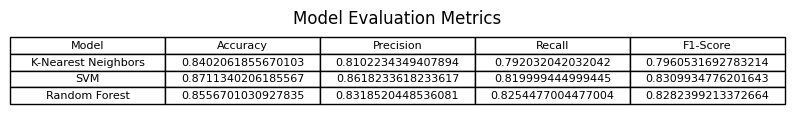

In [35]:
modelResultsOri_df = pd.DataFrame(modelResultsOri)
fig, ax = plt.subplots(figsize=(10, 1))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=modelResultsOri_df.values, colLabels=modelResultsOri_df.columns, cellLoc='center', loc='center')
plt.title('Model Evaluation Metrics')
plt.show()

In [49]:
def displayRes(images, title):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title(title + f' {i+1}')
    plt.show()

mendefinisikan fungsi rgb_to_hsv untuk keperluan color segmentation

In [50]:
def rgb_to_hsv(image):
    image = image.astype(np.float32) / 255.0
    hsv_image = np.zeros_like(image)
    
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    
    v = np.max(image, axis=-1)
    
    diff = v - np.min(image, axis=-1)
    s = np.zeros_like(v)
    s[v != 0] = diff[v != 0] / v[v != 0]

    h = np.zeros_like(v)
    
    mask = diff != 0
    mask_r = (mask) & (v == r)
    mask_g = (mask) & (v == g)
    mask_b = (mask) & (v == b)
    
    h[mask_r] = (60 * ((g[mask_r] - b[mask_r]) / diff[mask_r]) + 360) % 360
    h[mask_g] = (60 * ((b[mask_g] - r[mask_g]) / diff[mask_g]) + 120) % 360
    h[mask_b] = (60 * ((r[mask_b] - g[mask_b]) / diff[mask_b]) + 240) % 360
    
    hsv_image[..., 0] = h
    hsv_image[..., 1] = s
    hsv_image[..., 2] = v

    hsv_image[..., 0] = hsv_image[..., 0] / 2
    
    return hsv_image

mendefinisikan fungsi in_range untuk pemberian masking dalam color segmentation

In [51]:
def in_range(hsv, lower_bound, upper_bound):
    mask = np.ones(hsv.shape[:2], dtype=np.uint8)
    
    for i in range(3):
        mask &= (hsv[..., i] >= lower_bound[i]) & (hsv[..., i] <= upper_bound[i])
    
    return mask

mendefinisikan fungsi bitwise dalam color segmentation

In [52]:
def bitwise(image, mask):
    result = np.zeros_like(image)

    for i in range(3):
        result[..., i] = image[..., i] * mask
    
    return result

mendefinisikan fungsi color_segmentation untuk melakukan proses segmentasi warna dengan pendefinisian lower_green dan upper_green

In [53]:
def color_segmentation(images):
    segmented_images = []

    lower_green = np.array([30, 40 / 255, 40 / 255])
    upper_green = np.array([90, 255 / 255, 255 / 255])

    for image in images:
        hsv = rgb_to_hsv(np.copy(image))
        mask = in_range(hsv, lower_green, upper_green)
        segmented_image = bitwise(image, mask)
        segmented_images.append(np.copy(segmented_image))

    return segmented_images

In [54]:
segmented = color_segmentation(data)

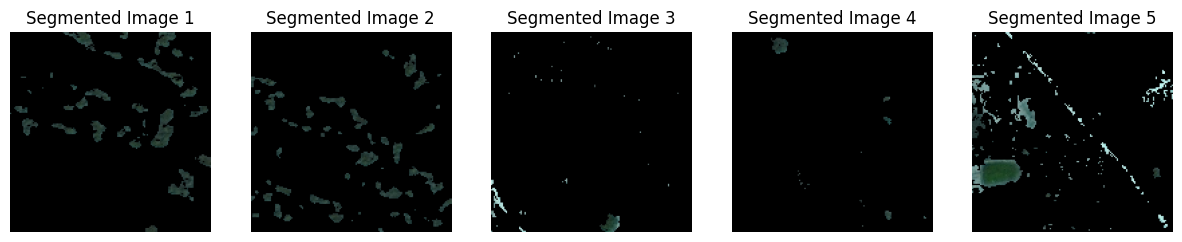

In [55]:
displayRes(segmented, "Segmented Image")

mendefinisikan fungsi untuk menghitung histogram untuk melakukan enhance citra

In [56]:
def calculate_histogram(image):
    hist = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        hist[pixel] += 1
    
    return hist

In [57]:
def calculate_cdf(hist):
    cdf = np.zeros_like(hist, dtype=float)
    cdf[0] = hist[0]
    for i in range(1, len(hist)):
        cdf[i] = cdf[i-1] + hist[i]
        
    return cdf

In [58]:
def normalize_cdf(cdf):
    cdf_min = cdf.min()
    cdf_max = cdf.max()
    
    if cdf_min == cdf_max:
        return np.full_like(cdf, 128, dtype='uint8')
    
    cdf_normalized = (cdf - cdf_min) * 255 / (cdf_max - cdf_min)
    
    return cdf_normalized.astype('uint8')

In [59]:
def apply_equalization(image, cdf_normalized):
    equalized_image = np.zeros_like(image, dtype='uint8')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            equalized_image[i, j] = cdf_normalized[image[i, j]]
            
    return equalized_image

In [60]:
def gray_to_bgr(gray_image):
    bgr_image = np.stack((gray_image,)*3, axis=-1)

    return bgr_image

In [61]:
def histogram_equalization(images):
    equalized_images = []

    for image in images:
        if len(image.shape) == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image

        hist = calculate_histogram(gray_image)
        cdf = calculate_cdf(hist)
        cdf_normalized = normalize_cdf(cdf)
        equalized_image = apply_equalization(gray_image, cdf_normalized)

        if len(image.shape) == 3:
            equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)

        equalized_images.append(np.copy(equalized_image))

    return equalized_images

In [62]:
def enhance_image(images):
    enhanced_images = []

    for image in images:
        gray = cv2.cvtColor(np.copy(image), cv2.COLOR_BGR2GRAY)
        equalized_image = histogram_equalization([gray])
        enhanced_images.append(np.copy(equalized_image[0]))

    return enhanced_images

In [63]:
enhanced = enhance_image(segmented)

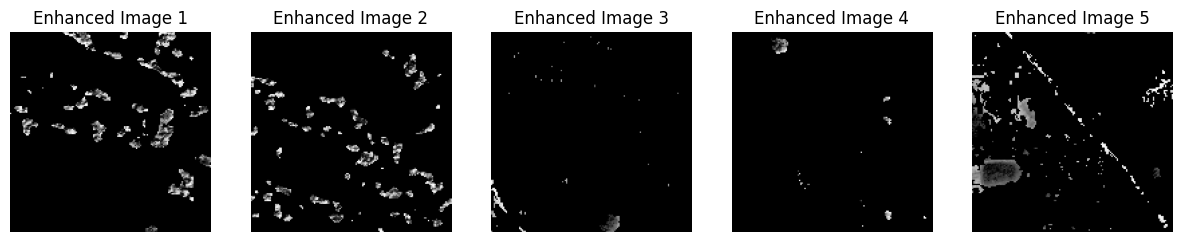

In [64]:
displayRes(enhanced, "Enhanced Image")

normalisasi citra

In [65]:
def normalize_images(images):
    normalized_images = []
    for img in images:
        img_float = img.astype(np.float32)

        min_val = np.min(img_float)
        max_val = np.max(img_float)
        
        if min_val == max_val:
            normalized_img = np.full_like(img, 128, dtype=np.uint8)
        else:
            normalized_img = (img_float - min_val) * (255.0 / (max_val - min_val))
            normalized_img = normalized_img.astype(np.uint8)

        normalized_images.append(np.copy(normalized_img))

    return normalized_images

In [66]:
normalized = normalize_images(enhanced)

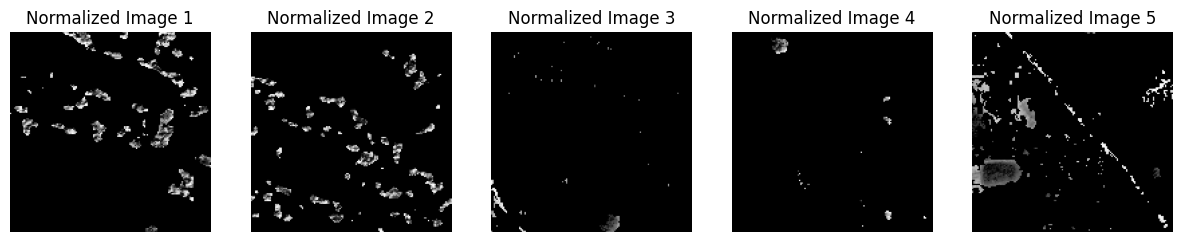

In [67]:
displayRes(normalized, "Normalized Image")

morfologi opening

In [68]:
def erode(image, kernel):
    eroded_image = np.ones_like(image, dtype=np.uint8) * 255

    ksize = kernel.shape[0]
    pad_amount = ksize // 2

    padded_image = np.pad(image, pad_amount, mode='constant', constant_values=255)

    for i in range(pad_amount, padded_image.shape[0] - pad_amount):
        for j in range(pad_amount, padded_image.shape[1] - pad_amount):
            image_patch = padded_image[i-pad_amount:i+pad_amount+1, j-pad_amount:j+pad_amount+1]
            eroded_image[i-pad_amount, j-pad_amount] = np.min(image_patch)
    
    return eroded_image

In [69]:
def dilate(image, kernel):
    dilated_image = np.zeros_like(image, dtype=np.uint8)

    ksize = kernel.shape[0]
    pad_amount = ksize // 2

    padded_image = np.pad(image, pad_amount, mode='constant', constant_values=0)

    for i in range(pad_amount, padded_image.shape[0] - pad_amount):
        for j in range(pad_amount, padded_image.shape[1] - pad_amount):
            image_patch = padded_image[i-pad_amount:i+pad_amount+1, j-pad_amount:j+pad_amount+1]
            dilated_image[i-pad_amount, j-pad_amount] = np.max(image_patch)
    
    return dilated_image

In [70]:
def opening(images, kernel_size):
    opened_images = []
    
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    
    for image in images:
        if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 3):
            if len(image.shape) == 3:
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray_image = image

            eroded_image = erode(gray_image, kernel)
            opened_image = dilate(eroded_image, kernel)
            
            opened_images.append(opened_image)
        else:
            print(f"Skipping image with invalid shape: {image.shape}")
    
    return opened_images

In [71]:
opened = opening(normalized, 2)

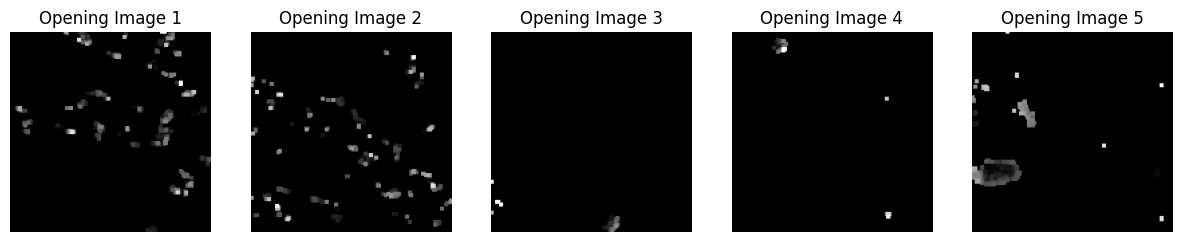

In [72]:
displayRes(opened, "Opening Image")

deteksi tepi

In [73]:
def convolve(image, kernel):
    img_height, img_width = image.shape
    ker_height, ker_width = kernel.shape

    pad_height = ker_height // 2
    pad_width = ker_width // 2

    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    result = np.zeros_like(image)

    for i in range(img_height):
        for j in range(img_width):
            region = padded_image[i:i+ker_height, j:j+ker_width]
            result[i, j] = np.sum(region * kernel)
    
    return result

In [74]:
def sobel(image):
    gradien_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    gradien_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])

    conv_gx = convolve(image, gradien_x)
    conv_gy = convolve(image, gradien_y)
    
    magnitude = np.sqrt(conv_gx**2 + conv_gy**2)
    
    if np.max(magnitude) != 0:
        magnitude = np.uint8(255 * magnitude / np.max(magnitude))
    else:
        magnitude = np.zeros_like(magnitude, dtype=np.uint8)

    return magnitude

In [75]:
def edge_detection(images):
    edge_images = []
    for image in images:
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        edges = sobel(gray)
        edge_images.append(edges)

    return edge_images

In [76]:
edge_detected = edge_detection(opened)

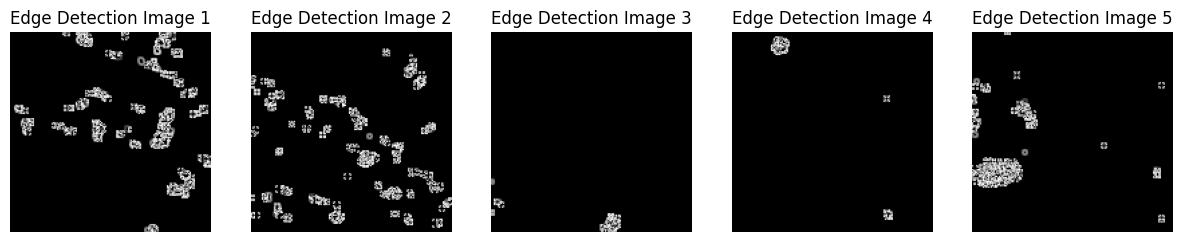

In [77]:
displayRes(edge_detected, "Edge Detection Image")

In [78]:
hasil = []
for img in edge_detected:
    res = []
    res.append(glcm0(img))
    res.append(glcm45(img))
    res.append(glcm90(img))
    res.append(glcm135(img))
    hasil.append(res)

In [79]:
part, correlation_val = featureAnalysis(hasil, labels)

In [80]:
df = pd.DataFrame(part, columns=headerCols)

In [81]:
df.to_csv('hasilPercobaan5.csv',index=False)

In [22]:
results = pd.read_csv('hasilPercobaan5.csv')
results

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,entropy_0,entropy_45,entropy_90,entropy_135,asm_0,asm_45,asm_90,asm_135,labels
0,7.158170e+08,5592321.0,0.881915,0.760572,0.720363,1.255871,0.760572,7.158170e+08,5592321.0,0.870700,...,1.257192,0.760107,7.158170e+08,5592321.0,0.871994,0.744559,0.616086,1.324082,0.744559,gundul
1,7.158170e+08,5592321.0,0.880896,0.756053,0.652269,1.194334,0.756053,7.158170e+08,5592321.0,0.868204,...,1.201018,0.754344,7.158170e+08,5592321.0,0.868880,0.735444,0.548146,1.279780,0.735444,gundul
2,7.158170e+08,5592321.0,0.989244,0.976339,0.759307,0.130880,0.976339,7.158170e+08,5592321.0,0.988422,...,0.128329,0.976605,7.158170e+08,5592321.0,0.988360,0.975203,0.672458,0.135540,0.975203,gundul
3,7.158170e+08,5592321.0,0.989091,0.976958,0.716976,0.127829,0.976958,7.158170e+08,5592321.0,0.988211,...,0.127206,0.977047,7.158170e+08,5592321.0,0.988115,0.975114,0.638507,0.136916,0.975114,gundul
4,7.158170e+08,5592321.0,0.940098,0.874466,0.757146,0.674122,0.874466,7.158170e+08,5592321.0,0.935294,...,0.686765,0.871624,7.158170e+08,5592321.0,0.935089,0.865674,0.688052,0.712724,0.865674,gundul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,7.158170e+08,5592321.0,0.989677,0.978285,0.741910,0.120534,0.978285,7.158170e+08,5592321.0,0.988976,...,0.122717,0.977754,7.158170e+08,5592321.0,0.988659,0.975559,0.617625,0.132485,0.975559,gundul
641,7.158170e+08,5592321.0,0.981109,0.959702,0.668114,0.211557,0.959702,7.158170e+08,5592321.0,0.979797,...,0.207589,0.960841,7.158170e+08,5592321.0,0.979439,0.955733,0.547453,0.228962,0.955733,gundul
642,7.158170e+08,5592321.0,0.944711,0.883951,0.690732,0.608322,0.883951,7.158170e+08,5592321.0,0.939417,...,0.606785,0.884875,7.158170e+08,5592321.0,0.940269,0.875763,0.612957,0.643905,0.875763,gundul
643,7.158170e+08,5592321.0,0.991281,0.981740,0.658244,0.101414,0.981740,7.158170e+08,5592321.0,0.990748,...,0.099415,0.982095,7.158170e+08,5592321.0,0.990664,0.980369,0.617504,0.107618,0.980369,gundul


In [23]:
best_features = features_score(results, 'labels')

print("Fitur terbaik berdasarkan skor:")
print(best_features)

Fitur terbaik berdasarkan skor:
              Feature         Score
21         entropy_45  1.891481e+09
7   dissimilarity_135  1.891481e+09
0          contrast_0  1.891481e+09
14          energy_90  1.891481e+09
8       homogeneity_0  1.475912e+07
22         entropy_90  1.475912e+07
15         energy_135  1.475912e+07
1         contrast_45  1.475912e+07
26             asm_90  1.811813e+03
12           energy_0  1.811454e+03
19    correlation_135  1.804968e+03
5    dissimilarity_45  1.802699e+03
13          energy_45  2.023073e+02
10     homogeneity_90  2.023073e+02
24              asm_0  2.022393e+02
27            asm_135  2.022393e+02
17     correlation_45  1.990506e+02
20          entropy_0  1.990506e+02
3        contrast_135  1.987663e+02
6    dissimilarity_90  1.987663e+02
9      homogeneity_45  1.304418e+02
23        entropy_135  1.303731e+02
16      correlation_0  1.212708e+02
2         contrast_90  1.205611e+02
25             asm_45  4.322077e+01
11    homogeneity_135  4.271466e

In [24]:
dataTrain = pd.read_csv('hasilPercobaan5.csv')

X = dataTrain[['entropy_45', 'dissimilarity_135', 'contrast_0', 'energy_90', 'homogeneity_0', 'entropy_90', 'energy_135', 'contrast_45', 'asm_90', 'energy_0', 'correlation_135', 'dissimilarity_45', 'energy_45', 'homogeneity_90', 'asm_0', 'asm_135', 'correlation_45', 'entropy_0', 'contrast_135', 'dissimilarity_90', 'homogeneity_45', 'entropy_135', 'correlation_0', 'contrast_90', 'asm_45', 'homogeneity_135', 'correlation_90', 'dissimilarity_0']]
y = dataTrain['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
X_train_scaled, X_test_scaled = normalize(X_train, X_test)

In [26]:
print("Data Pelatihan Setelah Normalisasi Min-Max:")
print(X_train_scaled)
print("\nData Pengujian Setelah Normalisasi Min-Max:")
print(X_test_scaled)

Data Pelatihan Setelah Normalisasi Min-Max:
     entropy_45  dissimilarity_135  contrast_0  energy_90  homogeneity_0  \
429         1.0                1.0         1.0        1.0            1.0   
210         1.0                1.0         1.0        1.0            1.0   
9           0.0                0.0         0.0        0.0            0.0   
519         1.0                1.0         1.0        1.0            1.0   
268         1.0                1.0         1.0        1.0            1.0   
..          ...                ...         ...        ...            ...   
71          1.0                1.0         1.0        1.0            1.0   
106         1.0                1.0         1.0        1.0            1.0   
270         1.0                1.0         1.0        1.0            1.0   
435         1.0                1.0         1.0        1.0            1.0   
102         1.0                1.0         1.0        1.0            1.0   

     entropy_90  energy_135  contrast_45   

K-Nearest Neighbors - Accuracy: 0.953608
K-Nearest Neighbors - Precision: 0.942381
K-Nearest Neighbors - Recall: 0.943815
K-Nearest Neighbors - F1-Score: 0.942242

Confusion Matrix for K-Nearest Neighbors:
[[97  0  2]
 [ 0 52  4]
 [ 3  0 36]]


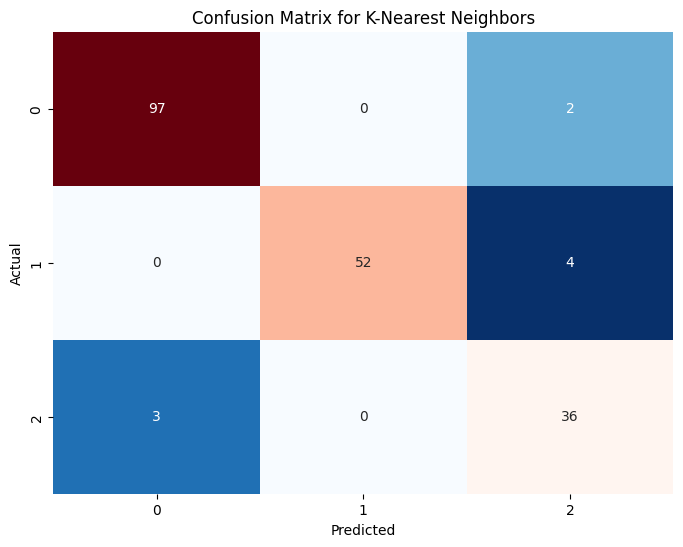

In [27]:
knn_model_fix = KNeighborsClassifier()
knn_model_fix.fit(X_train_scaled, y_train)
knn_metrics_fix = evaluate_model(knn_model_fix, X_test_scaled, y_test, 'K-Nearest Neighbors')

SVM - Accuracy: 0.963918
SVM - Precision: 0.956766
SVM - Recall: 0.953135
SVM - F1-Score: 0.954623

Confusion Matrix for SVM:
[[98  0  1]
 [ 0 53  3]
 [ 3  0 36]]


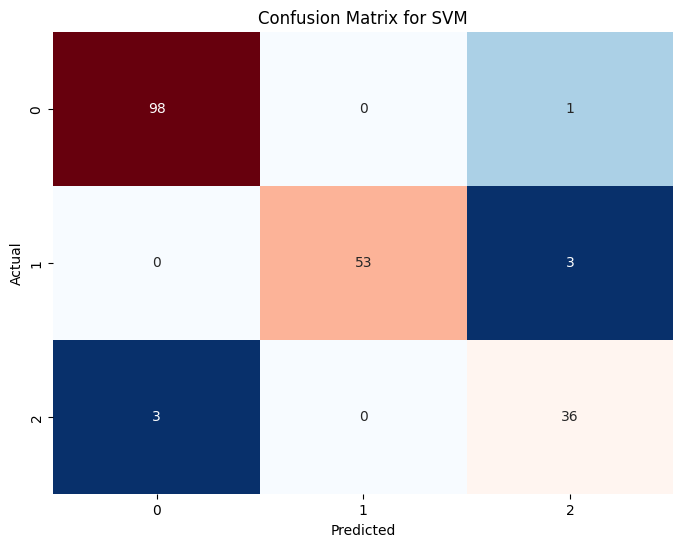

In [28]:
svm_model_fix = SVC()
svm_model_fix.fit(X_train_scaled, y_train)
svm_metrics_fix = evaluate_model(svm_model_fix, X_test_scaled, y_test, 'SVM')

Random Forest - Accuracy: 0.963918
Random Forest - Precision: 0.956766
Random Forest - Recall: 0.953135
Random Forest - F1-Score: 0.954623

Confusion Matrix for Random Forest:
[[98  0  1]
 [ 0 53  3]
 [ 3  0 36]]


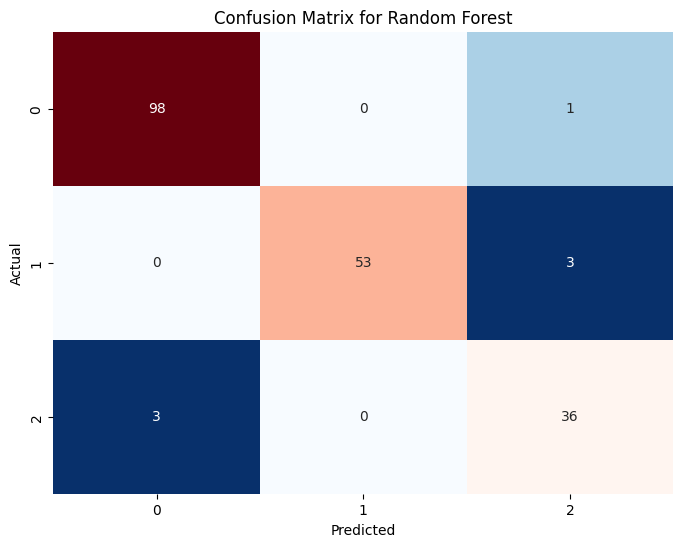

In [29]:
rf_model_fix = RandomForestClassifier()
rf_model_fix.fit(X_train_scaled, y_train)
rf_metrics_fix = evaluate_model(rf_model_fix, X_test_scaled, y_test, 'Random Forest')

In [30]:
modelResults = {
    'Model': ['K-Nearest Neighbors', 'SVM', 'Random Forest'],
    'Accuracy': [knn_metrics_fix[0], svm_metrics_fix[0], rf_metrics_fix[0]],
    'Precision': [knn_metrics_fix[1], svm_metrics_fix[1], rf_metrics_fix[1]],
    'Recall': [knn_metrics_fix[2], svm_metrics_fix[2], rf_metrics_fix[2]],
    'F1-Score': [knn_metrics_fix[3], svm_metrics_fix[3], rf_metrics_fix[3]]
}

In [31]:
modelResults_df = pd.DataFrame(modelResults)
print(modelResults_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0  K-Nearest Neighbors  0.953608   0.942381  0.943815  0.942242
1                  SVM  0.963918   0.956766  0.953135  0.954623
2        Random Forest  0.963918   0.956766  0.953135  0.954623


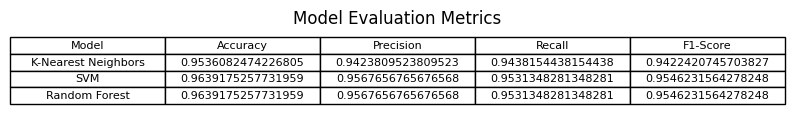

In [32]:
fig, ax = plt.subplots(figsize=(10, 1))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=modelResults_df.values, colLabels=modelResults_df.columns, cellLoc='center', loc='center')
plt.title('Model Evaluation Metrics')
plt.show()

In [32]:
def display_predictions(model, X_test_scaled, y_test, num_samples=50):
    y_pred = model.predict(X_test_scaled)
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    
    print(f"Displaying {num_samples} predictions for the model:")
    print(results.sample(num_samples))

In [33]:
display_predictions(knn_model_fix, X_test_scaled, y_test)

Displaying 50 predictions for the model:
             Actual       Predicted
256           lebat           lebat
257           lebat           lebat
236           lebat           lebat
148          gundul          gundul
493  setengahgundul  setengahgundul
284           lebat           lebat
289           lebat           lebat
234           lebat           lebat
10           gundul          gundul
312           lebat           lebat
109          gundul          gundul
398  setengahgundul  setengahgundul
215           lebat           lebat
248           lebat           lebat
620          gundul          gundul
70           gundul          gundul
442  setengahgundul  setengahgundul
155          gundul          gundul
311           lebat           lebat
264           lebat  setengahgundul
467  setengahgundul  setengahgundul
515          gundul          gundul
275           lebat           lebat
131          gundul          gundul
76           gundul          gundul
176           lebat    

In [34]:
display_predictions(rf_model_fix, X_test_scaled, y_test)

Displaying 50 predictions for the model:
             Actual       Predicted
628          gundul          gundul
76           gundul          gundul
281           lebat           lebat
620          gundul          gundul
485  setengahgundul  setengahgundul
212           lebat           lebat
524          gundul          gundul
443  setengahgundul  setengahgundul
167           lebat           lebat
42           gundul          gundul
31           gundul          gundul
66           gundul          gundul
82           gundul          gundul
592          gundul          gundul
114          gundul          gundul
108          gundul          gundul
608          gundul          gundul
302           lebat           lebat
118          gundul          gundul
11           gundul          gundul
286           lebat           lebat
331  setengahgundul  setengahgundul
72           gundul          gundul
598          gundul          gundul
6            gundul          gundul
208           lebat    

In [35]:
display_predictions(svm_model_fix, X_test_scaled, y_test)

Displaying 50 predictions for the model:
             Actual       Predicted
515          gundul          gundul
215           lebat           lebat
545          gundul          gundul
248           lebat           lebat
271           lebat           lebat
640          gundul          gundul
221           lebat           lebat
90           gundul          gundul
604          gundul          gundul
77           gundul          gundul
328           lebat  setengahgundul
281           lebat           lebat
633          gundul          gundul
236           lebat           lebat
10           gundul          gundul
132          gundul          gundul
404  setengahgundul  setengahgundul
533          gundul          gundul
434  setengahgundul  setengahgundul
286           lebat  setengahgundul
192           lebat           lebat
31           gundul          gundul
231           lebat           lebat
118          gundul          gundul
631          gundul          gundul
261           lebat    